In [7]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from sklearn.preprocessing import StandardScaler
from collections import deque
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

In [8]:
with open('scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)

with open('D:/Documents/GitHub/Final_Project/sets1/models/XGB_model.pkl','rb') as model_file:
    xgb_model = pickle.load(model_file)

print("Scaler and XGB model loaded successfully!")

Scaler and XGB model loaded successfully!


In [ ]:
#Load data stream
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [10]:
static_model = xgb_model
dynamic_model = copy.deepcopy(xgb_model)

In [11]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

print("Starting to consume messages...")

for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')
    
    try:
        row_df = pd.DataFrame([row], columns=[*feature_columns, 'label'])
    except ValueError:
        print(f"Skipping invalid row: {row}")
        continue
    
    if 'Unnamed: 0' in row_df.columns:
        row_df.drop('Unnamed: 0', axis=1, inplace=True)
    
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        # Ensure the 'label' column contains valid integers
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            print(f"Skipping row with invalid label: {row}")
            continue
        row_df['label'] = row_df['label'].astype(int)
    
    for col in feature_columns:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)
    
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns])
    X_new_static = static_scaler.transform(row_df[feature_columns])

    y_new = int(row_df['label'].values[0])

    dynamic_pred = dynamic_model.predict(X_new_dynamic)[0]
    static_pred  = static_model.predict(X_new_static)[0]
    
    window_data.append((X_new_dynamic[0], y_new, dynamic_pred, static_pred))
    
    if idx % 100 == 0:
        print(f"Consumed {idx} messages")
    
    if len(window_data) == window_size:
        # Extract ground truth and predictions from the window
        y_true = [entry[1] for entry in window_data]
        dynamic_preds = [entry[2] for entry in window_data]
        static_preds = [entry[3] for entry in window_data]
        
        # Compute the weighted F1-score
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        current_dynamic_precision = precision_score(y_true, dynamic_preds, average='weighted')
        current_dynamic_recall = recall_score(y_true, dynamic_preds, average='weighted')

        cm = confusion_matrix(y_true, dynamic_preds)

        if cm.shape == (2, 2):
            TN, FP, FN, TP = cm.ravel()
            false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0
        else:
            false_positive_rate = None

        try:
            fpr, tpr, _ = roc_curve(y_true, dynamic_preds)
            roc_auc = auc(fpr, tpr)
        except Exception:
            roc_auc = None

        print(f"\nWindow complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}, Precision: {current_dynamic_precision:.3f}, Recall: {current_dynamic_recall:.3f}, ", end='')
        if false_positive_rate is not None:
            print(f"FPR: {false_positive_rate:.3f}, ROC-AUC: {roc_auc:.3f}")
        else:
            print(f"ROC-AUC: {roc_auc:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")
        
        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Retrain if the F1-score is below the threshold and we haven't exceeded max retrains
        if current_dynamic_f1 < 0.92:
            print(f"Dynamic model F1 ({current_dynamic_f1:.3f}) is below threshold. Retraining dynamic model on this window...")
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])
            
            X_window_df = pd.DataFrame(X_window, columns=feature_columns)
            new_scaler = StandardScaler()
            new_scaler.fit(X_window_df)
            
            # Update the dynamic scaler gradually (EMA update)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_
            
            # Retrain the dynamic model on the window data
            dynamic_model.fit(X_window, y_window)

        # Clear the window for the next batch
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming from Kafka or timed out.")

Starting to consume messages...
Skipping row with invalid label: ['"destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd iat mean', 'bwd iat std', 'bwd iat max', 'bwd iat min', 'fwd psh flags', 'bwd psh flags', 'fwd urg flags', 'bwd urg flags', 'fwd header length', 'bwd header length', 'fwd packets/s', 'bwd packets/s', 'min packet length', 'max packet length', 'packet length mean', 'packet length std', 'packet length variance', 'fin flag count', 'syn flag count', 'rst flag count', 'psh flag count', 'ac

d:\Documents\GitHub\Final_Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages
Consumed 2000 messages

Window complete:
  Dynamic Model -> F1: 0.799, Precision: 0.823, Recall: 0.814, FPR: 0.039, ROC-AUC: 0.738
  Static Model  -> F1: 0.538
Dynamic model F1 (0.799) is below threshold. Retraining dynamic model on this window...
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Consumed 2400 messages
Consumed 2500 messages
Consumed 2600 messages
Consumed 2700 messages
Consumed 2800 messages
Consumed 2900 messages
Consumed 3000 messages

Window complete:
  Dynamic Model -> F1: 0.939, Precision: 0.939, Recall: 0.939, FPR: 0.036, ROC-AUC: 0.926
  Static Model  -> F1: 0.534
Consumed 3100 messages
Consumed 3200 messages
Consumed 3300 messages
Consumed 3400 messages
Consumed 3500 messages
Consumed 3600 messages
Consumed 3700 messages
Consumed 3800 mes

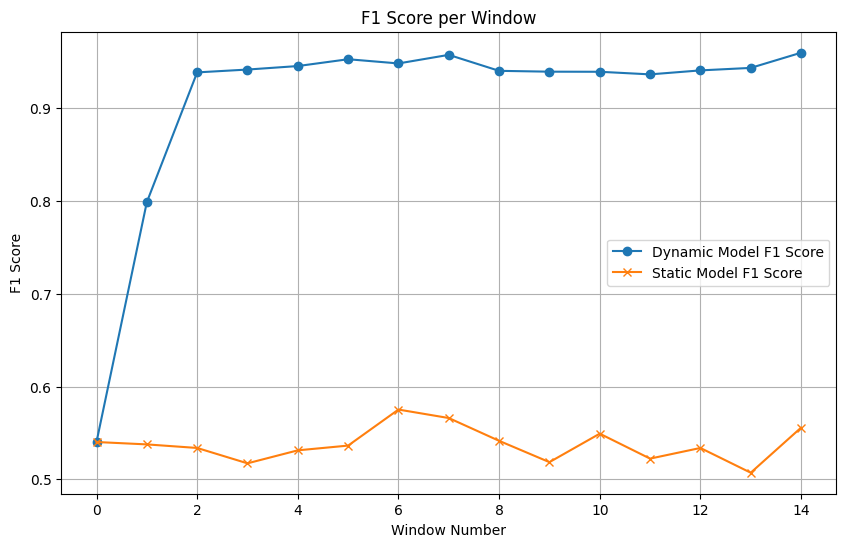

In [13]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()


Dynamic model performs much better than the static model